Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, October 9, 2015.

In [321]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import math
import random

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

Using least square error we find:  r =  0.117958553597 k =  1033.51531659
Using MLE we find:  r =  0.400460749626 k =  672.09265753
we plot the three curves here, where blue, green, and red correspond to data, LSE, MLE
standard error is  0.5858699300693492


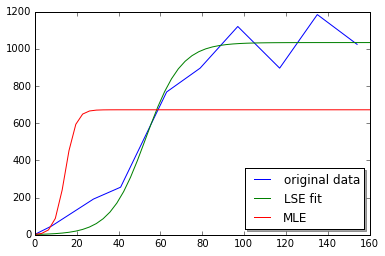

      jac: array([ -1.04904175e-05,  -2.98023224e-08])
        x: array([  4.00460750e-01,   6.72092658e+02])
     njev: 27
 hess_inv: array([[  9.37097606e-03,  -4.27350506e-01],
       [ -4.27350506e-01,   2.87017332e+04]])
   status: 0
      nit: 22
     nfev: 108
  message: 'Optimization terminated successfully.'
      fun: 3.4324357495946414
  success: True

In [302]:
# question 1
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024
N_0=2 # the population of day 0
def model(r, k, t): # predicted model
    return 2*k/(2+(k-2)*np.exp(-r*t))
def cost(theta): #theta=[r,k], establish cost function
    sum = 0
    i = 0
    for day in days:
        sum = sum + (model(theta[0], theta[1], day) - beetles[i])**2
        i = i + 1
    return sum
from scipy.optimize import minimize
res = minimize(cost, [1,1], tol=1e-6) #  minimize the sum of squared errors to find coefficients 
# plt.plot(days, beetles)
t = np.linspace(0, 160)
r = res.x[0]
k = res.x[1]
# plt.plot(t, model(r, k, t)) # plot the fitted curve to compare with the original data
print("Using least square error we find: ", "r = ", r, "k = ", k)
# question 2
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024
log_N_t = np.log(beetles)
sigma = 1 # can choose any sigma since it will be reduced as a constant
# theta=[r, k] use MLE to solve theta
from scipy.stats.distributions import norm
def cost(theta):
    log_f_t = []
    for day in days:
        log_f_t.append(np.log(model(theta[0], theta[1], day)))
    total = sum((log_f_t - log_N_t)**2)
    return total

opt = minimize(cost, [0.3, 700], tol=5*1e-5)
print("Using MLE we find: ", "r = ", opt.x[0], "k = ", opt.x[1])
print("we plot the three curves here, where blue, green, and red correspond to data, LSE, MLE")
print("standard error is ", math.sqrt(opt.fun/10))
# plt.plot(t, model(opt.x[0], opt.x[1], t), label="MLE")
# plt.show()

fig, ax = plt.subplots()
ax.plot(days, beetles, label='original data')
ax.plot(t, model(r, k, t), label='LSE fit')
ax.plot(t, model(opt.x[0], opt.x[1], t), label='MLE')
legend = ax.legend(loc='lower right', shadow=True)
plt.show()
#res
#opt
opt


An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



1.A solution: We compared different temperatures when tau_start = 20, 10, 5, and 1. In low temperatures, the curve become stuck at particular points for distinct periods because little tolerance for uphill moves is allowed when the temperature is low due to the Boltzmann factor. We also see that high temperature usually requires more iterations to find the minimized AIC. We compared different durations at each temperature by tuning the durating length of different periods. We fing that the longer time we assign to the early periods, the less likely the curve will get stuck. This can be understood as a result of longer duration of high temperature.

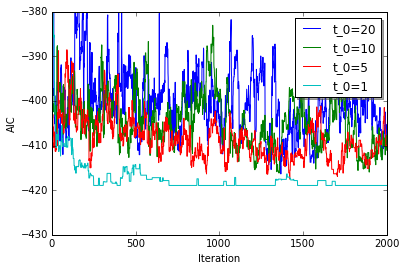

In [329]:
baseball = pd.read_table('../data/textbook/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)
def aic_values(t_0):
    periods = 15
    cooling = [60]*int(periods/3) + [120]*int(periods/3) + [220]*int(periods/3)
    tau_start = t_0
    tau = [tau_start]*periods
    aic_values = []

    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = pd.ols(y=logsalary, x=solution_vars)
    aic_best = aic(g)
    aic_values.append(aic_best)

    # Cooling schedule
    tau = [tau_start * 0.9**i for i in range(15)]

    for j in range(periods):
        for i in range(cooling[j]):   
            # Random change 1-neighborhood
            flip = np.random.randint(0, ncols)
            solution_current[flip] = not solution_current[flip]
            solution_vars = predictors[predictors.columns[solution_current]]
            g = pd.ols(y=logsalary, x=solution_vars)
            aic_step = aic(g)
            alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau[j]))
        
            if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                aic_values.append(aic_step)
                if aic_step < aic_best:
                    # Replace previous best with this one
                    aic_best = aic_step
                    solution_best = solution_current.copy()
            else:
                # Revert solution
                solution_current[flip] = not solution_current[flip]
                aic_values.append(aic_values[-1])
    return aic_values    
# plt.plot(aic_values(10))
# plt.plot(aic_values(1))
# plt.xlim(0, len(aic_values(10)))
# plt.xlabel('Iteration')
# plt.ylabel('AIC')

x = range(0, len(aic_values(10)))
fig, ax = plt.subplots()
ax.plot(x, aic_values(20), label='t_0=20')
ax.plot(x, aic_values(10), label='t_0=10')
ax.plot(x, aic_values(5), label='t_0=5')
ax.plot(x, aic_values(1), label='t_0=1')
plt.ylim(-430, -380)
plt.xlabel('Iteration')
plt.ylabel('AIC')
legend = ax.legend(loc='upper right', shadow=True)
plt.show()


1.B solution: We changed the 1-neighborhood to 2-neighborhood and then 3-neighborhood. There is no great difference between 2 and 3.

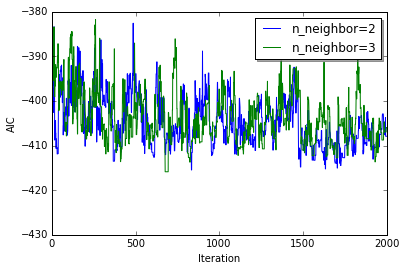

In [330]:
def aic_values(n_neighbor):
    periods = 15
    cooling = [60]*int(periods/3) + [120]*int(periods/3) + [220]*int(periods/3)
    tau_start = 10
    tau = [tau_start]*periods
    aic_values = []

    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = pd.ols(y=logsalary, x=solution_vars)
    aic_best = aic(g)
    aic_values.append(aic_best)

    # Cooling schedule
    tau = [tau_start * 0.9**i for i in range(15)]

    for j in range(periods):
        for i in range(cooling[j]): 
            if n_neighbor == 2:
                flip = random.sample(range(0,ncols),2)
                solution_current[flip[0]] = not solution_current[flip[0]]
                solution_current[flip[1]] = not solution_current[flip[1]]
            if n_neighbor == 3:
                flip = random.sample(range(0,ncols),3)
                solution_current[flip[0]] = not solution_current[flip[0]]
                solution_current[flip[1]] = not solution_current[flip[1]]
                solution_current[flip[2]] = not solution_current[flip[2]]
            solution_vars = predictors[predictors.columns[solution_current]]
            g = pd.ols(y=logsalary, x=solution_vars)
            aic_step = aic(g)
            alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau[j]))
        
            if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                aic_values.append(aic_step)
                if aic_step < aic_best:
                    # Replace previous best with this one
                    aic_best = aic_step
                    solution_best = solution_current.copy()
            else:
                # Revert solution
                if n_neighbor == 2:
                    solution_current[flip[0]] = not solution_current[flip[0]]
                    solution_current[flip[1]] = not solution_current[flip[1]]
                if n_neighbor == 3:
                    solution_current[flip[0]] = not solution_current[flip[0]]
                    solution_current[flip[1]] = not solution_current[flip[1]]
                    solution_current[flip[2]] = not solution_current[flip[2]]
                aic_values.append(aic_values[-1])
    return aic_values    
# plt.plot(aic_values(10))
# plt.plot(aic_values(1))
# plt.xlim(0, len(aic_values(10)))
# plt.xlabel('Iteration')
# plt.ylabel('AIC')

x = range(0, len(aic_values(2)))
fig, ax = plt.subplots()
ax.plot(x, aic_values(2), label='n_neighbor=2')
ax.plot(x, aic_values(3), label='n_neighbor=3')
plt.ylim(-430, -380)
plt.xlabel('Iteration')
plt.ylabel('AIC')
legend = ax.legend(loc='upper right', shadow=True)
plt.show()

2.A solution: We compare the effect of using different mutation rates of 0, 0.02, 0.04, and 0.1. It is shown that a local minimum is found instead of a global minimum when the rate is zero. This is because a small mutation reduces the rate at which we explore the solution space. It is also shown that AIC does not converge for iterations up to 100 when the mutation is too large. This is because frequent mutation disrupts the inheritance of high-value schema. That said, it is harder to purify the high fittness characters.

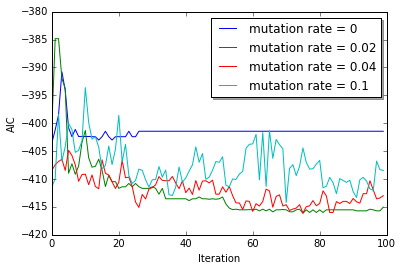

In [337]:
def aic_genetic(mutation):
    pop_size = 20
    iterations = 100
    mutation_rate = mutation

    aic_best = []
    best_solution = []
    aic_history = []

    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

    def calculate_fitness(aic_values):
        P = len(aic_values)
        aic_rank = (-aic_values).argsort().argsort()+1.
        return 2.*aic_rank/(P*(P+1.))

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return aic_best

# plt.plot(aic_genetic(0.02))
# plt.plot(aic_genetic(0))

x = range(0, 100)
fig, ax = plt.subplots()
ax.plot(x, aic_genetic(0), label='mutation rate = 0')
ax.plot(x, aic_genetic(0.02), label='mutation rate = 0.02')
ax.plot(x, aic_genetic(0.04), label='mutation rate = 0.04')
ax.plot(x, aic_genetic(0.1), label='mutation rate = 0.1')
plt.xlabel('Iteration')
plt.ylabel('AIC')
legend = ax.legend(loc='upper right', shadow=True)
plt.show()

2.B solution: We compare the effects of using different generation sizes of 10, 20, 30, and 40. We see that it is necessary to choose a large generation size for early generations in order to discourage premature convergence and promote search diversity. In theory, one would desire a larger $P$ for the sake of smaller AIC (i.e. better result). But this is at the compromise of more computation time. In practice, we can decrease $P$ after early generations since population fitness usually improves very rapidly during early generations.

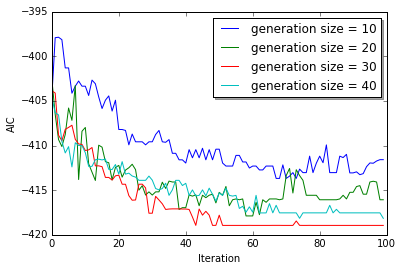

In [349]:
def aic_genetic(P):
    pop_size = P
    iterations = 100
    mutation_rate = 0.02

    aic_best = []
    best_solution = []
    aic_history = []

    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

    def calculate_fitness(aic_values):
        P = len(aic_values)
        aic_rank = (-aic_values).argsort().argsort()+1.
        return 2.*aic_rank/(P*(P+1.))

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return aic_best

x = range(0, 100)
fig, ax = plt.subplots()
ax.plot(x, aic_genetic(10), label='generation size = 10')
ax.plot(x, aic_genetic(20), label='generation size = 20')
ax.plot(x, aic_genetic(30), label='generation size = 30')
ax.plot(x, aic_genetic(40), label='generation size = 40')
plt.xlabel('Iteration')
plt.ylabel('AIC')
egend = ax.legend(loc='upper right', shadow=True)
plt.show()

2.C solution: See the code as belows. We see that it's smoother than the the class example with fewer oscillations.

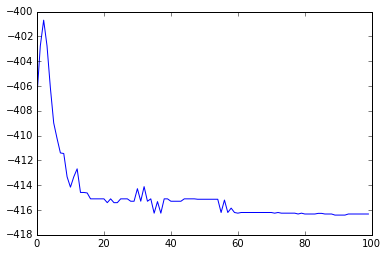

In [350]:
pop_size = 20
iterations = 100
mutation_rate = .02

aic_best = []
best_solution = []
aic_history = []

# Initialize genotype
current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

for i in range(iterations):
    
    # Get phenotype
    current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
    # Calculate AIC
    current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
    # Get lowest AIC
    aic_best.append(current_aic[np.argmin(current_aic)])
    best_solution.append(current_gen[np.argmin(current_aic)])
    
    # Calculate fitness according to AIC rank
    fitness = calculate_fitness(current_aic)
    
    # Choose first parents according to fitness
    moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
    # Choose second parents randomly
    dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
    
    next_gen = []
    for x,y in zip(current_gen[moms], current_gen[dads]):
        # Crossover
        cross = np.random.randint(0, ncols)
        child1 = np.r_[x[:cross], y[cross:]]
        child2 = np.r_[y[:cross], x[cross:]]
        # Mutate
        m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
        child1[m1] = abs(child1[m1]-1)
        m2 = np.random.binomial(1, mutation_rate, size=ncols)
        child2[m2] = abs(child1[m2]-1)
        next_gen += [child1, child2]
        
    # Increment generation
    current_gen = np.array(next_gen)
    # Store AIC values
    aic_history.append(current_aic)
    
plt.plot(aic_best)

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there. I will award 5 bonus points to the best solution!

In [376]:
###declaration: I refered to the online source of the ant group algorithm.

def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

#save the lat and lon data to a position array
N = 26
i = 0
city = range(0, N) #0, 1, 2, ...25
pos = [] #pos[0][0] = 0th city latitude
for lat_val in cities['lat']:
    temp = []
    temp.append(cities['lat'][i])
    temp.append(cities['lon'][i])
    pos.append(temp)
    i = i + 1
 

    
#######
import random
import copy
import time
import sys

( ALPHA, BETA, RHO, Q ) = ( 1.0, 2.0, 0.5, 100.0 )
( city_num, ant_num, iter_max ) = ( 26, 34, 1000 )

distance_x = []
distance_y = []
for i in range(0, len(pos)):
    distance_x.append(pos[i][0])
    distance_y.append(pos[i][1])

distance_graph = [ [ 0.0 for col in range( city_num ) ] for raw in range( city_num ) ]
pheromone_graph = [ [ 1.0 for col in range( city_num ) ] for raw in range( city_num ) ]

class Ant( object ):
    def __init__( self, ID ):
        self.ID = ID
        self.__clean_data()
    def __lt__( self, other ):
        return self.total_distance < other.total_distance

    def __clean_data( self ):
        self.path = []
        self.total_distance = 0.0
        self.move_count = 0
        self.current_city = -1
        self.open_table_city = [ True for i in range( city_num ) ]

        city_index = random.randint( 1, city_num - 1 )
        self.current_city = city_index
        self.path.append( city_index )
        self.open_table_city[city_index] = False
        self.move_count = 1

    def __choice_next_city( self ):
        next_city = -1
        select_citys_prob = [ 0.0 for i in range( city_num ) ]
        total_prob = 0.0
        if total_prob > 0.0:
            temp_prob = random.uniform( 0.0, total_prob )
            for i in range( city_num ):
                if self.open_table_city[i]:
                    temp_prob -= select_citys_prob[i]
                    if temp_prob < 0.0:
                        next_city = i
                        break

        if next_city == -1:
            for i in range( city_num ):
                if self.open_table_city[i]:
                    next_city = i
                    break

        return next_city

    def __cal_total_distance( self ):
        temp_distance = 0.0

        for i in range( 1, city_num ):
            start, end = self.path[i], self.path[i - 1]
            temp_distance += distance_graph[start][end]

        end = 0
        temp_distance += distance_graph[start][end]
        self.total_distance = temp_distance

    def __move( self, next_city ):
        self.path.append( next_city )
        self.open_table_city[next_city] = False
        self.total_distance += distance_graph[self.current_city][next_city]
        self.current_city = next_city
        self.move_count += 1

    def search_path( self ):
        self.__clean_data()

        while self.move_count < city_num:
            next_city = self.__choice_next_city()
            self.__move( next_city )
        self.__cal_total_distance()

class TSP( object ):
    def __init__( self ):
        self.ants = [ Ant( ID ) for ID in range( ant_num ) ]
        self.best_ant = Ant( -1 )
        self.best_ant.total_distance = 1 << 31

        for i in range( city_num ):
            for j in range( city_num ):
                temp_distance = pow( ( distance_x[i] - distance_x[j] ), 2 ) + pow( ( distance_y[i] - distance_y[j] ), 2 )
                temp_distance = pow( temp_distance, 0.5 )
                distance_graph[i][j] = float( int( temp_distance + 0.5 ) )
                pheromone_graph[i][j] = 1.0

    def search_path( self ):
        for i in range( iter_max ):
            for ant in self.ants:
                ant.search_path()
                if ant < self.best_ant:
                    self.best_ant = copy.deepcopy( ant )
            self.__update_pheromone_graph()
            # print self.best_ant.total_distance

    def __update_pheromone_graph( self ):
        temp_pheromone = [ [ 0.0 for col in range( city_num ) ] for raw in range( city_num ) ]
        for ant in self.ants:
            for i in range( 1, city_num ):
                start, end = ant.path[i - 1], ant.path[i]
                temp_pheromone[start][end] += Q / ant.total_distance
                temp_pheromone[end][start] = temp_pheromone[start][end]

            end = ant.path[0]
            temp_pheromone[start][end] += Q / ant.total_distance
            temp_pheromone[end][start] = temp_pheromone[start][end]

        for i in range( city_num ):
            for j in range( city_num ):
                pheromone_graph[i][j] = pheromone_graph[i][j] * RHO + temp_pheromone[i][j]

if __name__ == '__main__':
    test = TSP()
    test.search_path()
    print("Best Distance: ", test.best_ant.total_distance)


Best Distance:  253.0


## Question 4

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$g(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is posi- tive).
2. Using the prior density as a proposal density, design a rejection algo- rithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [109]:
#question 1
from scipy.stats.distributions import norm
from scipy.stats.distributions import binom
def g(theta, y, mu, sigma, n):
    return math.exp(y*theta)*math.exp(-(theta-mu)**2/(2*sigma**2))/(1+math.exp(theta))**n
def g_trans(theta, y, mu, sigma, n):
    return y*theta-n*np.log(1+math.exp(theta))-(theta-mu)**2/(2*sigma**2)

from scipy.optimize import fmin_bfgs

g_min = lambda *args: -g_trans(*args)

init_value = 0

opt = fmin_bfgs(g_min, init_value, 
          args=(5, 0, 0.5, 5), full_output=True)
mode, var = opt[0], opt[3]
Q4_1 = 1 - norm.cdf(0, mode , math.sqrt(var))
print("The probability that the coin is biased toward heads is ", Q4_1)

Optimization terminated successfully.
         Current function value: 2.869167
         Iterations: 3
         Function evaluations: 15
         Gradient evaluations: 5
The probability that the coin is biased toward heads is  [ 0.86187626]


In [117]:
#question 2
def propose_trans(theta, mu, sigma):
    return -(theta-mu)**2/(2*sigma**2)
def calc_diff(theta, y, mu, sigma, n):
    return g_trans(theta, y, mu, sigma, n) - propose_trans(theta, mu, sigma)
calc_diff_min = lambda *args: -calc_diff(*args)
opt = fmin_bfgs(calc_diff_min, 0, args=(5, 0, 0.5, 5), full_output=True)
c = opt[1]

from scipy.stats.distributions import norm
generate_theta = lambda size: np.random.normal(0, 0.5, size)

def reject(y, mu, sigma, n, c, samples):
    
    # Draw samples from g(theta)
    theta = generate_theta(samples)
    
    # Calculate probability under g(theta)=proposed
    gvals = np.array([np.log(norm.pdf(t, mu, sigma)) for t in theta])

    # Calculate probability under f(theta)=posterior
    fvals = np.array([np.log(g(t, y, mu, sigma, n)) for t in theta])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(samples) < p]
total_sample = reject(5, 0, 0.5, 5, c, 10000)
Q4_2 = np.sum(total_sample > 0) / len(total_sample)
print("The probability that the coin is biased toward heads is ", Q4_2)

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 17
         Function evaluations: 54
         Gradient evaluations: 18
The probability that the coin is biased toward heads is  0.857594936709


In [124]:
#question 3
samples = 10000
theta = generate_theta(samples)
p_propose_theta = np.array([norm.pdf(t, 0, 0.5) for t in theta])
p_post_theta = np.array([g(t, 5, 0, 0.5, 5) for t in theta])
w = p_post_theta / p_propose_theta
w = w/w.sum()
theta_sir = theta[np.random.choice(range(len(theta)), size = samples, p=w)]
Q4_3 = np.sum(theta_sir > 0)/len(theta_sir)
print("The probability that the coin is biased toward heads is ", Q4_3)

The probability that the coin is biased toward heads is  0.8628
